In [1]:
"""環境"""
# .lab

"""更新履歴"""
# 最終更新日：2025/08/04
# 2025/08/04 cachedirの洗浄をオプションにしました。
# 2025/07/22 pickleを保存するために、pickleとdatetimeをインポートするようにしました。
# 2025/07/17 inputsを保存するjsonを作ることにしました
# 2025/07/17 ctypesを使ってtkinterの解像度を上げることにしました
# 2025/05/21 shutilを使って、cachedirを洗浄することにしました
# 2025/05/15 simple_progress_barおよびdata(dict)を使い始めました。
# 2025/02/25 os.getcwd()を採用し、__file__を定義する必要をなくしました。

"""モジュール読み込み"""
# ファイル操作等
import sys
import os
from datetime import datetime
from pprint import pprint
import logging
import pickle
# import struct
from tqdm import tqdm
import h5py
# import threading
import json
import shutil

# tkinter
from tkinter import filedialog, messagebox, Tk
import ctypes
ctypes.windll.shcore.SetProcessDpiAwareness(1) # tkinterの解像度を上げる

# データ分析ツール
import pandas as pd
import numpy as np
import scipy as sp
# import math
# from sklearn.linear_model import LinearRegression

# グラフ等作成用
import matplotlib
import matplotlib.pyplot as plt         # 図の作成用
from PIL import Image as im
# import cv2
from IPython.display import display, HTML, clear_output, update_display, Image

# 自作モジュール
sys.path.append(r"C:\Users\okaza\pythonenv")
from modules.Mytools.Tools import print_fileinfo, h5_tree, dict_tree, simple_progress_bar, clean_cache_except_logfiles, get_total_size
import modules.Mytools.Settings
import modules.fitXRD as fx
from modules.peakfit import peakfit, pseudoVoigt

"""ログ管理ツール作成"""
# chche directoryの設定
cachedir = os.path.abspath(os.getcwd() + "/.cache")
if False:
    clean_cache_except_logfiles(cachedir)
os.makedirs(cachedir, exist_ok=True)

# loggerの作成
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
format = "%(levelname)-9s  %(asctime)s [%(filename)s:%(lineno)d] %(message)s"

# Streamハンドラクラスを作成
sh = logging.StreamHandler()
sh.setLevel(logging.DEBUG)
sh.setFormatter(logging.Formatter(format))
logger.addHandler(sh)

# Fileハンドラクラスをインスタンス化
logfile = cachedir + ""
fh = logging.FileHandler(filename=cachedir + "/notebook.log", encoding="utf-8")
fh.setLevel(logging.DEBUG)
fh.setFormatter(logging.Formatter(format))
logger.addHandler(fh)
logger.debug("[Activate workspace]: " + os.getcwd())
logger.debug("[Set cache]: "+ os.path.abspath(cachedir))
logger.debug("[Activate log]: " + os.path.abspath(cachedir + "/notebook.log"))

# globalなデータを作成
data = dict()
logger.debug("[Create global variable]: data")

# inputをjsonファイルに保存する
data["inputs"] = os.path.join(cachedir, "input.json")
with open(data["inputs"], mode = "w") as f:
    json.dump(dict(), f)
logger.info("[Set json for save inputs]: " + os.path.abspath(data["inputs"]) )

DEBUG      2025-08-07 16:25:58,224 [1617289364.py:79] [Activate workspace]: c:\Users\okaza\pythonenv\lf\dist
DEBUG      2025-08-07 16:25:58,226 [1617289364.py:80] [Set cache]: c:\Users\okaza\pythonenv\lf\dist\.cache
DEBUG      2025-08-07 16:25:58,226 [1617289364.py:81] [Activate log]: c:\Users\okaza\pythonenv\lf\dist\.cache\notebook.log
DEBUG      2025-08-07 16:25:58,227 [1617289364.py:85] [Create global variable]: data
INFO       2025-08-07 16:25:58,229 [1617289364.py:91] [Set json for save inputs]: c:\Users\okaza\pythonenv\lf\dist\.cache\input.json


## 目的

温度を2色法で簡単に計算し、時空間プロファイルを作成します。

## 1. ファイル読み込み

In [2]:
from modules.SpeReadPy.read_spe import SpeReference
import xml.etree.ElementTree as ET
import re

生データを読み込みます。

In [3]:
def read_spe():

    # spe生データ
    spefile = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-06\Okazaki\UODE15\LF_1\UODE15  0005.spe"

    if True: # [ Main ]
        # データ読み込み
        spe = SpeReference(spefile)
        logger.info("[File]: " + os.path.abspath(spefile))

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = dict()
        data[key]["data"] = spe.get_data()[0]
        data[key]["wavelength"] = spe.get_wavelengths()[0]
        data[key]["spefile"] = spefile
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
read_spe()
del read_spe

INFO       2025-08-07 16:26:06,976 [342704374.py:9] [File]: C:\Users\okaza\Box\DataStrorage\SPring8-2025-06\Okazaki\UODE15\LF_1\UODE15  0005.spe


INFO       2025-08-07 16:26:09,066 [342704374.py:17] [Add variables]: read_spe (data = 2367.75 MB)



├── inputs <class 'str'>
└── read_spe
    ├── data <class 'numpy.ndarray'> [shape = (579, 400, 1340)]
    ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
    └── spefile <class 'str'>

メタデータを出力します。

In [4]:
def show_metadata():

    # speオブジェクト
    spe = SpeReference(data["read_spe"]["spefile"])

    # ETオブジェクトから辞書を作成する関数
    def element_to_dict(elem) -> tuple:
        """
        XML要素 (Element) を辞書に変換します。
        """
        tag = re.sub(r"\{.*?\}", "", elem.tag)
        d = [element_to_dict(child) for child in elem]
        if not d:
            text = elem.text.strip() if elem.text and elem.text.strip() else None
            return tag, text
        else:
            return tag, dict([element_to_dict(child) for child in elem])

    # メタデータの辞書を作成
    root = ET.fromstring(spe.xml_footer)
    d = dict([element_to_dict(root)])#["SpeFormat"]["DataHistories"]["DataHistory"]["Origin"]["Experiment"]["Devices"]["Cameras"]["Camera"] # type: ignore

    # jsonとして出力
    key = sys._getframe().f_code.co_name
    jsonfilename = os.path.join(cachedir, key + ".json")
    with open(jsonfilename, mode = "w") as f:
        json.dump(d, f, indent = 4)
    logger.debug("[Save json]: " + jsonfilename)

    # データ格納
    data[key] = dict()
    data[key]["jsonfile"] = jsonfilename
    logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
    dict_tree(data)

    logger.info("[Exposure time]: {} ms".format(d["SpeFormat"]["DataHistories"]["DataHistory"]["Origin"]["Experiment"]["Devices"]["Cameras"]["Camera"]["ShutterTiming"]["ExposureTime"]))
    logger.info("[Frame rate]: {} Hz".format(d["SpeFormat"]["DataHistories"]["DataHistory"]["Origin"]["Experiment"]["Devices"]["Cameras"]["Camera"]["Acquisition"]["FrameRate"]))
    logger.info("[Filter]: {}".format(d["SpeFormat"]["DataHistories"]["DataHistory"]["Origin"]["Experiment"]["Devices"]["Spectrometers"]["Spectrometer"]["FilterWheel"]["Filter"]["Name"]))

    return
show_metadata()
del show_metadata

DEBUG      2025-08-05 11:28:27,526 [275760318.py:28] [Save json]: c:\Users\okaza\pythonenv\lf\dist\.cache\show_metadata.json
INFO       2025-08-05 11:28:27,528 [275760318.py:33] [Add variables]: show_metadata (data = 2367.75 MB)
INFO       2025-08-05 11:28:27,529 [275760318.py:36] [Exposure time]: 300 ms
INFO       2025-08-05 11:28:27,531 [275760318.py:37] [Frame rate]: 2.6361970790356404 Hz
INFO       2025-08-05 11:28:27,533 [275760318.py:38] [Filter]: OD0



├── inputs <class 'str'>
├── read_spe
│   ├── data <class 'numpy.ndarray'> [shape = (579, 400, 1340)]
│   ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
│   └── spefile <class 'str'>
└── show_metadata
    └── jsonfile <class 'str'>

校正データを読み込みます。

In [5]:
def add_calib():

    # ランプデータ
    spectrumdata = r"C:\Users\okaza\pythonenv\twocolors\ReferenceData\OL245C.csv"

    # フィルターデータ
    standard_up = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-05\CeO2\Tcalib_BLAZE_20250514\standard\0_Up_std.spe"
    standard_down = r"C:\Users\okaza\Box\DataStrorage\SPring8-2025-05\CeO2\Tcalib_BLAZE_20250514\standard\0-Down_std.spe"

    if True: # [ Main ]
        
        # 補正データの読み込み
        std_data = dict()
        std_data["OD"] = dict()
        std_data["OD"]["up"] = SpeReference(standard_up).get_data()[0][0]
        std_data["OD"]["down"] = SpeReference(standard_down).get_data()[0][0]
        std_data["spectrum"] = dict()
        std_data["spectrum"]["csvdata"] = pd.read_csv(spectrumdata).values.T
        logger.debug("[Load]: std_data")

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = std_data
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
        dict_tree(data)

    return
add_calib()
del add_calib

DEBUG      2025-08-05 11:29:06,021 [210197429.py:19] [Load]: std_data
INFO       2025-08-05 11:29:06,023 [210197429.py:24] [Add variables]: add_calib (data = 2367.75 MB)



├── inputs <class 'str'>
├── read_spe
│   ├── data <class 'numpy.ndarray'> [shape = (579, 400, 1340)]
│   ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
│   └── spefile <class 'str'>
├── show_metadata
│   └── jsonfile <class 'str'>
└── add_calib
    ├── OD
    │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
    │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
    └── spectrum
        └── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]

## 2. 校正

In [6]:
def calibration():

    # スペクトルデータの補完
    spectrum_interp = sp.interpolate.interp1d(
        *data["add_calib"]["spectrum"]["csvdata"],
        kind = "cubic"
    )
    data["add_calib"]["spectrum"]["interp"] = spectrum_interp(data["read_spe"]["wavelength"])
    logger.debug("[Calc]: Interpolation of spectrum data")

    # 補正
    calibrated = dict()
    calibrated["wavelength"] = data["read_spe"]["wavelength"]
    calibrated["data"] = (
        data["read_spe"]["data"]
        * np.stack(
            [np.vstack(
                [data["add_calib"]["spectrum"]["interp"]]*data["read_spe"]["data"].shape[1]
            )]*data["read_spe"]["data"].shape[0],
            axis = 0
        )
        / np.stack(
            [np.vstack(
                [data["add_calib"]["OD"]["up"]]*(data["read_spe"]["data"].shape[1]//2)
                + [data["add_calib"]["OD"]["down"]]*(data["read_spe"]["data"].shape[1]//2)
            )]*data["read_spe"]["data"].shape[0],
            axis = 0
        )
    )
    logger.debug("[Calc]: Correction")

    # データ格納
    key = sys._getframe().f_code.co_name
    data[key] = dict()
    data[key]["calibrated"] = calibrated
    logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))
    dict_tree(data)

    return
calibration()
del calibration

DEBUG      2025-08-05 11:29:22,896 [3453187679.py:9] [Calc]: Interpolation of spectrum data
DEBUG      2025-08-05 11:29:31,492 [3453187679.py:30] [Calc]: Correction
INFO       2025-08-05 11:29:31,494 [3453187679.py:36] [Add variables]: calibration (data = 4735.49 MB)



├── inputs <class 'str'>
├── read_spe
│   ├── data <class 'numpy.ndarray'> [shape = (579, 400, 1340)]
│   ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
│   └── spefile <class 'str'>
├── show_metadata
│   └── jsonfile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
└── calibration
    └── calibrated
        ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
        └── data <class 'numpy.ndarray'> [shape = (579, 400, 1340)]

## 3. 波長選択

In [7]:
import matplotlib.animation as anim

参考にするフレームとpix位置を指定します。

INFO       2025-08-05 11:30:23,685 [3431605374.py:45] [Add variables]: set_refframe (data = 4735.49 MB)
DEBUG      2025-08-05 11:30:24,111 [3431605374.py:100] [Save fig]: c:\Users\okaza\pythonenv\lf\dist\.cache\set_refframe.png


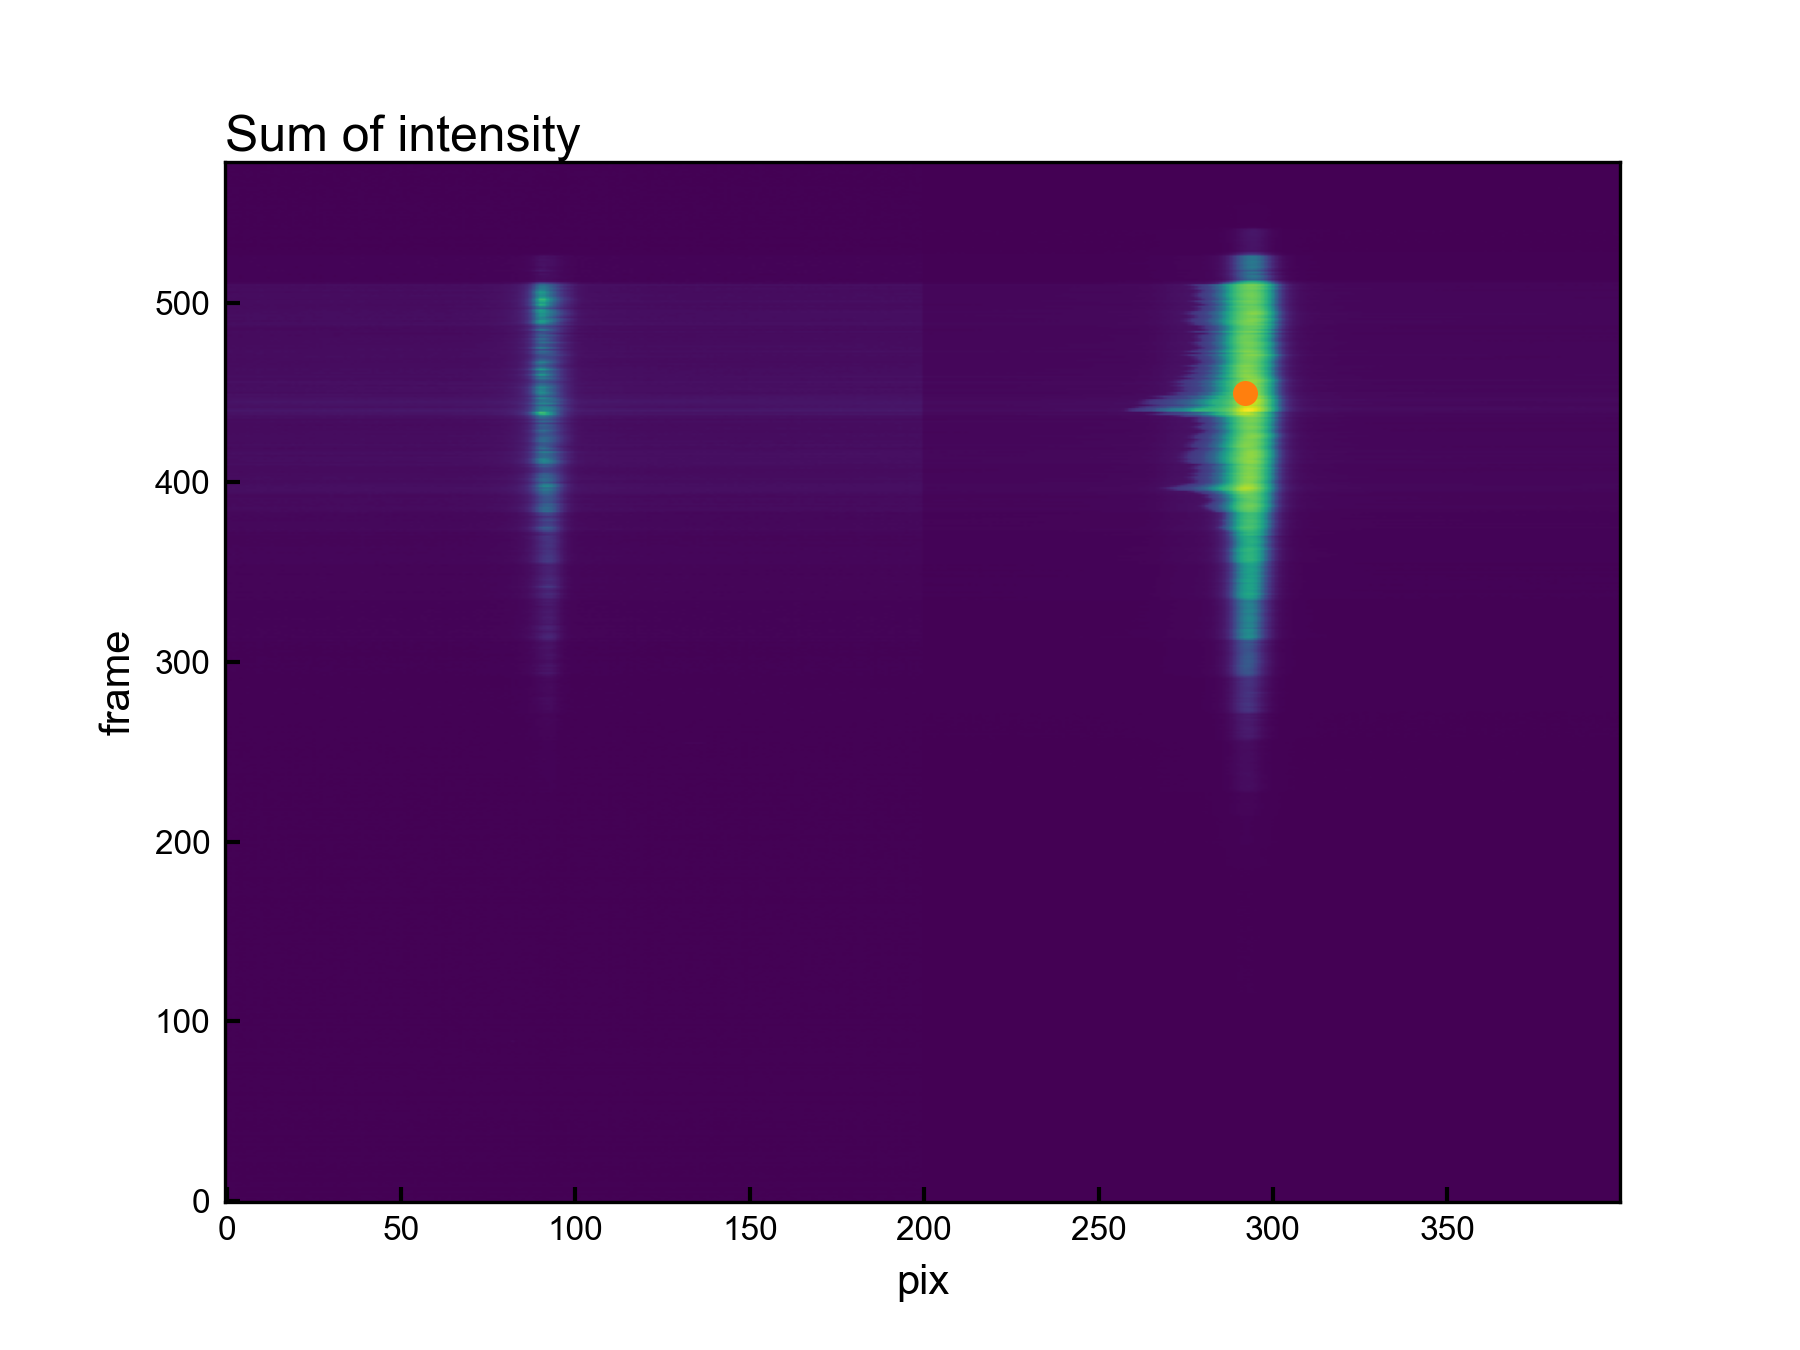


├── inputs <class 'str'>
├── read_spe
│   ├── data <class 'numpy.ndarray'> [shape = (579, 400, 1340)]
│   ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
│   └── spefile <class 'str'>
├── show_metadata
│   └── jsonfile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── calibration
│   └── calibrated
│       ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
│       └── data <class 'numpy.ndarray'> [shape = (579, 400, 1340)]
└── set_refframe
    ├── pix <class 'int'>
    └── frame <class 'int'>

In [14]:
def set_refframe():

    # 表示範囲 (optional)
    # xlim = (80,110)
    # xlim = (250,300)
    # xlim = (300,400)
    # ylim = (0,50)

    # 空間位置
    ref_pix = 292
    # ref_pix = 90

    # 時間位置
    ref_frame = 450

    # グラフサイズ
    size_inches = (6,4.5)

    if True: # Main
        # データの作成
        sumdata = np.sum(data["calibration"]["calibrated"]["data"], axis = -1)
        # sumdata = data["calibration"]["calibrated"]["data"][:,:,200]

        # 例外処理
        try:
            xlim # type: ignore
        except:
            xlim = (0, -1)
            flag_x = False
        else:
            flag_x = True
        try:
            ylim # type: ignore
        except:
            ylim = (0, -1)
            flag_y = False
        else:
            flag_y = True

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = dict()
        data[key]["pix"] = ref_pix
        data[key]["frame"] = ref_frame
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # figの作成
        fig, ax = plt.subplots()
        fig.set_size_inches(size_inches)
        fig.set_dpi(300)

        # axの作成
        ax.set_xlabel("pix", fontsize = 10)
        ax.set_ylabel("frame", fontsize = 10)

        # 最大値最小値を検知
        vmax = np.max(sumdata[ylim[0]:ylim[1], xlim[0]:xlim[1]])
        vmin = np.min(sumdata[ylim[0]:ylim[1], xlim[0]:xlim[1]])

        # imshow and plot
        ax.imshow(
            sumdata,
            aspect = "auto",
            vmax = vmax,
            vmin = vmin,
            origin = "lower"
        )
        ax.plot(
            [ref_pix],
            [ref_frame],
            lw = 0,
            marker = "o",
            ms = 6,
            mew = 0,
            mfc = "tab:orange"
        )
        
        # 範囲指定
        ax.set_xlim(xlim if flag_x else ax.get_xlim())
        ax.set_ylim(ylim if flag_y else ax.get_ylim())
        ax.text(
            x = 0,
            y = 1.01,
            s = "Sum of intensity",
            fontsize = 12,
            transform = ax.transAxes
        )

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # 出力
        display(Image(filename = imgfilename, width = size_inches[0]*100))
        dict_tree(data)

    return
set_refframe()
del set_refframe

指定したピクセルにおける波形の変化をアニメーションにします。

In [15]:
def anim_profile():

    # # 変数読込
    wl_raw = data["read_spe"]["wavelength"] # nm
    it_raw = data["read_spe"]["data"][:, data["set_refframe"]["pix"]]
    wl_cal = data["calibration"]["calibrated"]["wavelength"] # nm
    it_cal = data["calibration"]["calibrated"]["data"][:, data["set_refframe"]["pix"]]

    # フレーム数
    n_frame = it_raw.shape[0]

    fig, axs = plt.subplots(2,1)
    fig.set_size_inches((6,8))

    axs[0].set_ylim((it_raw.min(), it_raw.max()))
    axs[1].set_ylim((it_cal.min(), it_cal.max()))

    ims = []
    ims.append(axs[0].plot(
        wl_raw,
        it_raw[0],
        lw = 1,
        c = "0"
    )[0])
    ims.append(axs[1].plot(
        wl_cal,
        it_cal[0],
        lw = 1,
        c = "0"
    )[0])
    ims.append(axs[0].text(
        x = 0,
        y = 1.01,
        s = "frame = {:>4}".format(0),
        fontsize = 12,
        transform = axs[0].transAxes
    ))

    axs[0].text(
        x = 0.01,
        y = 0.98,
        s = "raw",
        fontsize = 10,
        transform = axs[0].transAxes,
        ha = "left",
        va = "top"
    )

    axs[1].text(
        x = 0.01,
        y = 0.98,
        s = "calibrated",
        fontsize = 10,
        transform = axs[1].transAxes,
        ha = "left",
        va = "top"
    )

    def update(frame):
        ims[0].set_ydata(it_raw[frame])
        ims[1].set_ydata(it_cal[frame])
        ims[2].set_text("frame = {:>4}".format(frame))
        
        # axs[0].set_ylim((it_raw[frame].min(), it_raw[frame].max()))  # フレームごとに縦軸変更
        # axs[1].set_ylim((it_cal[frame].min(), it_cal[frame].max()))  # フレームごとに縦軸変更
        return ims

    ani = anim.FuncAnimation(fig, update, frames=n_frame)
    plt.close()

    #. Save
    logger.debug("[Save]: Animation")
    # ani = anim.ArtistAnimation(fig, ims, interval = 300)
    key = sys._getframe().f_code.co_name
    filename = os.path.join(cachedir, key + ".mp4")
    ani.save(filename, writer = "ffmpeg", fps = 30, dpi = 300)
    logger.info("[Save]: " + os.path.abspath(filename))

    return
anim_profile()
del anim_profile

DEBUG      2025-08-05 11:30:29,518 [2202637071.py:72] [Save]: Animation
INFO       2025-08-05 11:31:55,576 [2202637071.py:77] [Save]: c:\Users\okaza\pythonenv\lf\dist\.cache\anim_profile.mp4


キャリブレーション後のデータをウィーンプロットに載せます。

In [16]:
def anim_wien():

    # # 変数読込
    wl_cal = data["calibration"]["calibrated"]["wavelength"] # nm
    it_cal = data["calibration"]["calibrated"]["data"][:, data["set_refframe"]["pix"]]

    # フレーム数
    n_frame = it_cal.shape[0]

    x = -1/wl_cal
    imin = np.unique(np.abs(it_cal))[1]
    it_cal[it_cal <= 0] = imin
    y = (np.log(it_cal) + 5*np.log(wl_cal))

    fig, ax = plt.subplots()
    fig.set_size_inches((6,4.5))

    ax.set_ylim((y.min(), y.max()))

    ims = []
    ims.append(ax.plot(
        x,
        y[0],
        lw = 1,
        c = "0"
    )[0])
    ims.append(ax.text(
        x = 0,
        y = 1.01,
        s = "frame = {:>4}".format(0),
        fontsize = 12,
        transform = ax.transAxes
    ))

    def update(frame):

        ims[0].set_ydata(y[frame])
        ims[1].set_text("frame = {:>4}".format(frame))
        
        return ims

    ani = anim.FuncAnimation(fig, update, frames=n_frame)
    plt.close()

    #. Save
    logger.debug("[Save]: Animation")
    # ani = anim.ArtistAnimation(fig, ims, interval = 300)
    key = sys._getframe().f_code.co_name
    filename = os.path.join(cachedir, key + ".mp4")
    ani.save(filename, writer = "ffmpeg", fps = 30, dpi = 300)
    logger.info("[Save]: " + os.path.abspath(filename))



    return
anim_wien()
del anim_wien

DEBUG      2025-08-05 11:34:42,887 [1846096722.py:46] [Save]: Animation
INFO       2025-08-05 11:35:40,515 [1846096722.py:51] [Save]: c:\Users\okaza\pythonenv\lf\dist\.cache\anim_wien.mp4


温度計算をする波長ペアを決定します。

DEBUG      2025-08-05 11:38:22,683 [3789075947.py:85] [Save fig]: c:\Users\okaza\pythonenv\lf\dist\.cache\wavelength_pair.png
INFO       2025-08-05 11:38:22,686 [3789075947.py:95] [Add variables]: wavelength_pair (data = 4735.49 MB)


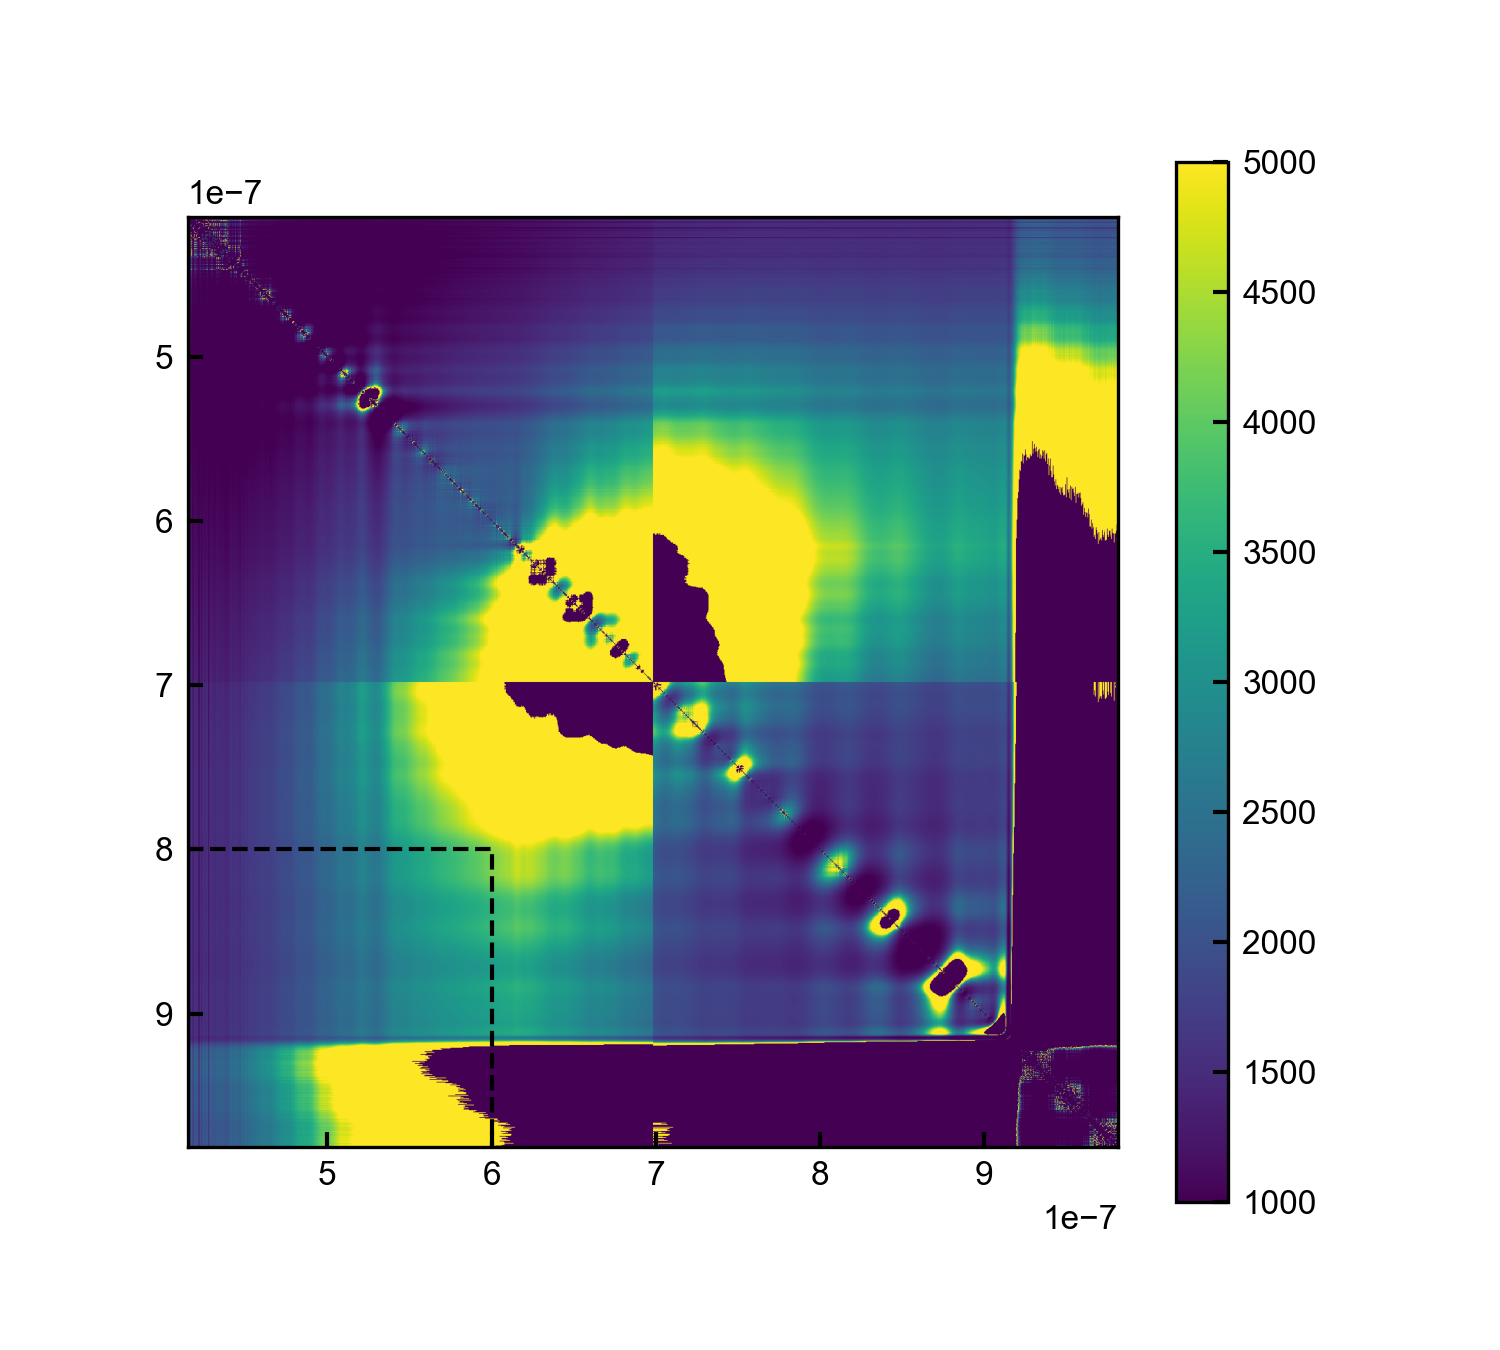


├── inputs <class 'str'>
├── read_spe
│   ├── data <class 'numpy.ndarray'> [shape = (579, 400, 1340)]
│   ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
│   └── spefile <class 'str'>
├── show_metadata
│   └── jsonfile <class 'str'>
├── add_calib
│   ├── OD
│   │   ├── up <class 'numpy.ndarray'> [shape = (1, 1340)]
│   │   └── down <class 'numpy.ndarray'> [shape = (1, 1340)]
│   └── spectrum
│       ├── csvdata <class 'numpy.ndarray'> [shape = (2, 225)]
│       └── interp <class 'numpy.ndarray'> [shape = (1340,)]
├── calibration
│   └── calibrated
│       ├── wavelength <class 'numpy.ndarray'> [shape = (1340,)]
│       └── data <class 'numpy.ndarray'> [shape = (579, 400, 1340)]
├── set_refframe
│   ├── pix <class 'int'>
│   └── frame <class 'int'>
└── wavelength_pair
    └── wavelengths <class 'tuple'>

In [20]:
def wavelength_pair():

    # 波長ペア
    wavelengths = (600, 800) # nm

    # 表示する温度範囲
    temp_range = (1000, 5000)
    
    if True:
        # 変数読込
        constants = 1e-9 # m/nm
        wl = data["calibration"]["calibrated"]["wavelength"] * constants # m
        it = data["calibration"]["calibrated"]["data"][data["set_refframe"]["frame"], data["set_refframe"]["pix"]]
        index = np.arange(it.shape[0]) # type: ignore

        # 統合データ作成
        dataframe = np.vstack([index, wl, it])

        # マスク処理
        mask = ~np.tril(np.ones([dataframe.shape[1]]*2)).astype(np.bool_)
        nonzeromask = np.prod(np.stack(np.meshgrid(*([(dataframe[2] > 0)]*2)), axis = -1), axis = -1).astype(np.bool_)
        mask *= nonzeromask

        # 温度計算
        # 波長
        wset = np.stack(np.meshgrid(*([dataframe[1]]*2)), axis = -1)[mask].T
        lnW = np.log(wset[0]/wset[1])
        invW = (np.reciprocal(wset[0]) - np.reciprocal(wset[1]))
        # 強度
        iset = np.stack(np.meshgrid(*([dataframe[2]]*2)), axis = -1)[mask].T
        lnR = np.log(iset[0]/iset[1])
        # 温度
        temperature = -sp.constants.h*sp.constants.c/sp.constants.Boltzmann * invW / (lnR + 5 * lnW)

        # 計算した温度を成形する
        base = np.zeros([dataframe.shape[1]]*2)
        base[mask] = temperature
        base = base.T
        base[mask] = temperature

        # figを作成
        fig, ax = plt.subplots()
        fig.set_size_inches((5,4.5))
        fig.set_dpi(300)

        # cmap
        cmap = ax.imshow(
            base,
            vmax = temp_range[1],
            vmin = temp_range[0],
            extent = (
                dataframe[1][0],
                dataframe[1][-1],
                dataframe[1][-1],
                dataframe[1][0]
            ),
            aspect="equal",
            zorder = 0
        )
        ax.set_xlim(ax.get_xlim())
        ax.set_ylim(ax.get_ylim())

        # plot
        ax.plot(
            [ax.get_xlim()[0], *([wavelengths[0]*constants] * 2)],
            [*([wavelengths[1]*constants]*2), ax.get_ylim()[0]],
            lw = 1,
            zorder = 1,
            c = "0",
            ls = "dashed"
        )

        # 画像の保存
        fig.colorbar(mappable=cmap)
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()

        # データ格納
        key = sys._getframe().f_code.co_name
        data[key] = dict()
        data[key]["wavelengths"] = wavelengths
        logger.info("[Add variables]: {} (data = {:.2f} MB)".format(key, float(get_total_size(data))/1024/1024))

        # 表示
        display(Image(filename = imgfilename, width = 500))
        dict_tree(data)

    return
wavelength_pair()
del wavelength_pair

## 4. 温度計算

温度の計算をします。

INFO       2025-08-05 11:39:01,003 [636001370.py:23] [Calc] wavelength 1 = 5.998e-07 m
INFO       2025-08-05 11:39:01,005 [636001370.py:24] [Calc] wavelength 2 = 8.000e-07 m
INFO       2025-08-05 11:39:01,017 [636001370.py:34] [Calc]: zero intensity: 171529
DEBUG      2025-08-05 11:39:01,458 [636001370.py:91] [Save fig]: c:\Users\okaza\pythonenv\lf\dist\.cache\calc_temp.png


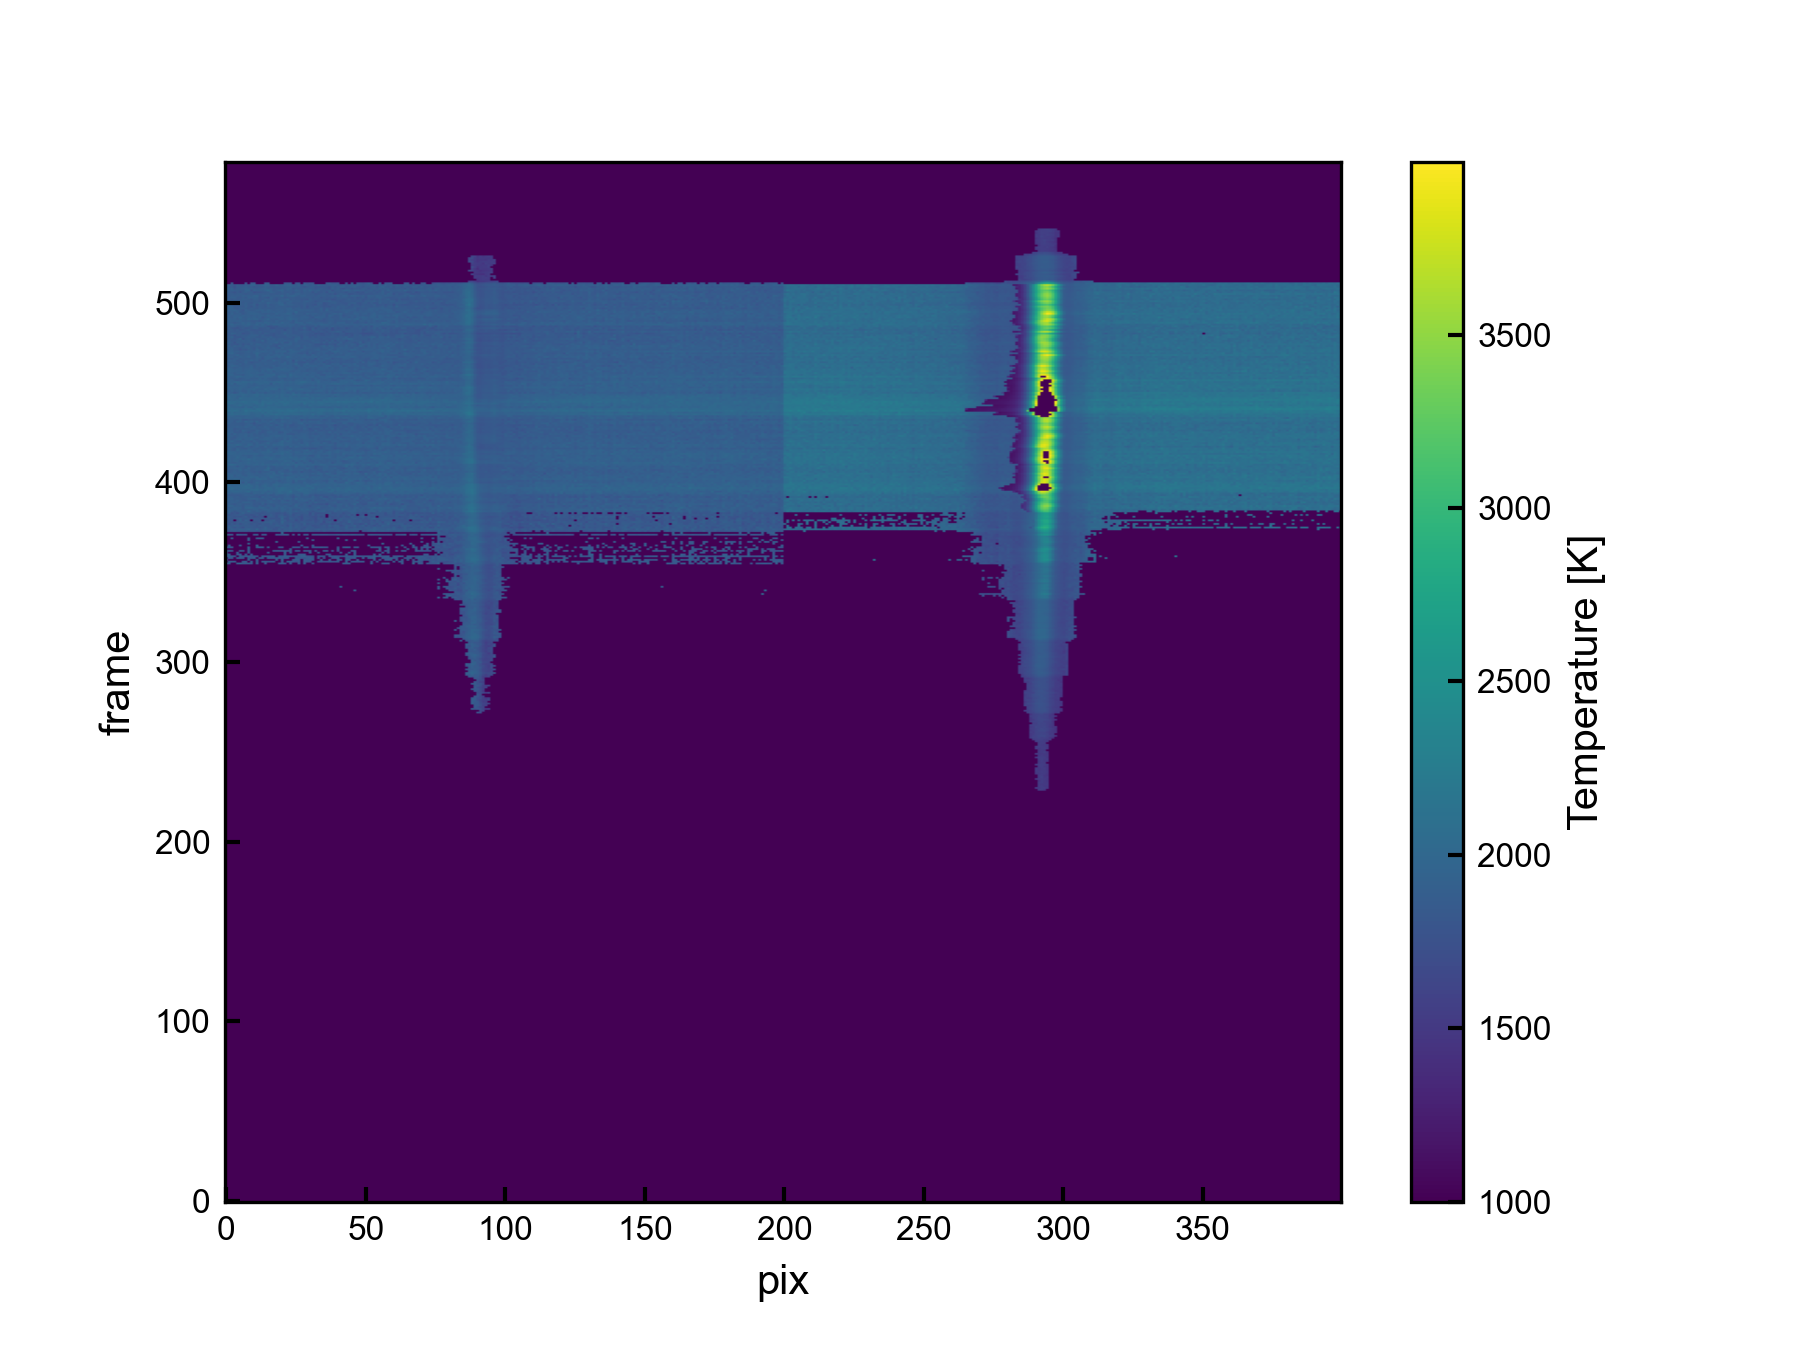

In [24]:
def calc_temp():

    # 温度範囲
    temp_range = (1000, 4000)

    # グラフサイズ
    size_inches = (6,4.5)

    # thresholod
    intsty_threshold = 1e-3

    if True: # Main

        # データ読み込み
        constants = 1e-9 # m/nm
        w1 = data["wavelength_pair"]["wavelengths"][0] * constants # m
        w2 = data["wavelength_pair"]["wavelengths"][1] * constants # m
        wavelength = data["read_spe"]["wavelength"] * constants

        # 波長ペアの決定
        arg1 = np.argmin(np.abs(wavelength - w1))
        arg2 = np.argmin(np.abs(wavelength - w2))
        logger.info("[Calc] wavelength 1 = {:.3e} m".format(wavelength[arg1]))
        logger.info("[Calc] wavelength 2 = {:.3e} m".format(wavelength[arg2]))

        # 強度データを抽出
        intensity = data["calibration"]["calibrated"]["data"]
        i1 = intensity.transpose(2,0,1)[arg1]
        i2 = intensity.transpose(2,0,1)[arg2]
        n_frame = i1.shape[0]

        # ゼロ値の検出
        zeromask = ((np.abs(i1) < intsty_threshold) + (np.abs(i2) < intsty_threshold)).astype(np.bool_)
        logger.info("[Calc]: zero intensity: {}".format(np.sum(zeromask)))

        # ゼロ値が存在する場合
        base = np.zeros(i1.shape)
        if (np.sum(zeromask) != 0):
            flag_zero = True
        else:
            flag_zero = False

        # 温度計算
        # 波長
        lnW = np.log(wavelength[arg1]/wavelength[arg2])
        invW = (np.reciprocal(wavelength[arg1]) - np.reciprocal(wavelength[arg2]))
        # 強度
        if flag_zero:
            lnR = np.log((i1[~zeromask]/i2[~zeromask]))
        else:
            lnR = np.log((i1/i2))
        # 温度
        temperature = -sp.constants.h*sp.constants.c/sp.constants.Boltzmann * invW / (lnR + 5 * lnW)

        if flag_zero:
            base[~zeromask] = temperature
            temperature = base.copy()

        # フィルター処理
        temperature[temperature < temp_range[0]] = temp_range[0]
        temperature[temperature > temp_range[1]] = temp_range[0]

        # fig作成
        fig, ax = plt.subplots()
        fig.set_size_inches(size_inches)
        fig.set_dpi(300)

        # axの設定
        ax.set_xlabel("pix", fontsize = 10)
        ax.set_ylabel("frame", fontsize = 10)

        map = ax.imshow(
            temperature,
            origin = "lower",
            aspect = "auto",
            cmap = "viridis"
        )
        fig.colorbar(mappable = map, ax = ax).set_label("Temperature [K]", fontsize = 10)

        # 画像の保存
        fig.canvas.draw()
        img = im.frombuffer(
            mode = "RGBA",
            size = fig.canvas.get_width_height(),
            data = fig.canvas.buffer_rgba(), # type: ignore
            decoder_name = "raw"
        )
        key = sys._getframe().f_code.co_name
        imgfilename = cachedir + "/{}.png".format(key)
        img.save(imgfilename)
        logger.debug("[Save fig]: " + os.path.abspath(imgfilename))        
        # pdffilename = cachedir + "/{}.pdf".format(key)
        # plt.savefig(pdffilename)
        # logger.debug("[Save fig]: " + os.path.abspath(pdffilename))
        plt.close()
        display(Image(filename = imgfilename, width = 600))


    return
calc_temp()
del calc_temp